<a href="https://colab.research.google.com/github/KumudaBG/Deep-Learning-Assignment6/blob/main/partA_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import MNIST data

In [1]:
import sys,numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [2]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


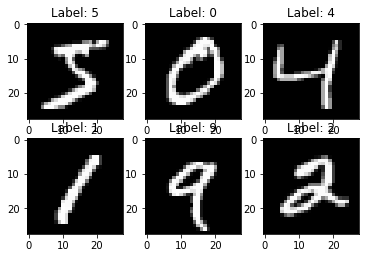

In [3]:
plt.figure(figsize=[6,6])
for i in range(6):
  plt.subplot(3,3,i+1)
  plt.title("Label: %i"%ytrain[i])
  plt.imshow(xtrain[i].reshape([28,28]),cmap='gray')

In [4]:
images=xtrain.reshape(len(xtrain),28*28)/255
test_images=xtest.reshape(len(xtest),28*28)/255

In [5]:
trainlabels=np.zeros((len(ytrain),10))
for i,l in enumerate(ytrain):
  trainlabels[i][l]=1

In [6]:
testlabels=np.zeros((len(ytest),10))
for i,l in enumerate(ytest):
  testlabels[i][l]=1

#Tensor with multiple features support

In [7]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))

    def softmax(self):
        x = self.data - self.data.max(axis=1, keepdims=True)
        y = np.exp(x)
        v = y / y.sum(axis=1, keepdims=True)

        if(self.autograd):
            return Tensor(v,
                          autograd=True,
                          creators=[self],
                          creation_op="softmax")
        return Tensor(v)
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))


[ True  True  True  True  True]


In [8]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

In [ ]:
data = Tensor((xtrain[:10]), autograd=True)# data indices
target = Tensor((ytrain[:10]), autograd=True) # target indices

w = list()
w.append(Tensor(np.random.rand(xtrain.shape[1],64), autograd=True))
w.append(Tensor(np.random.rand(64,10), autograd=True))

optim = SGD(parameters=w, alpha=0.01)

for i in range(10):
    pred = data.mm(w[0]).mm(w[1]).softmax() # Predict 
    loss = ((pred - target)*(pred - target)).sum(0) # Compare
    loss.backward(Tensor(np.ones_like(loss.data))) # Learn
    optim.step()
    print(loss)